# Chapter 4 クラスタリング

## 4.1 クラスタリング

### クラスタリングの目的関数

Juliaでは，ベクトルのリストを，$N$個のベクトルのリストかタプルで扱うことができる．このリストを`x`とすると，`x[i]`で$i$番目の要素（つまり$i$番目のベクトル）にアクセスできる．各ベクトルに割り当てるクラスタを指定するための割り当てリストを`assignment`としよう．ここで`assignment[i]`は，ベクトル`x[i]`が割り当てられるグループの番号（1から$k$の整数）である（本書第4章では，代入を表すためにベクトル$c$や部分集合$G_j$を使っている）．また$k$個のクラスタ代表を表すリストを`resp`としよう．ここで`resp[j]`は$j$番目のクラスタ代表である（本書ではこれらのクラスタ代表を$z_1, \ldots, z_k$で表している）．

In [1]:
using LinearAlgebra, VMLS

┌ Info: Recompiling stale cache file /Users/tamaki/.julia/compiled/v1.0/VMLS/7CbiM.ji for VMLS [44dac47c-a70e-11e8-3cff-fbf5f1f7c554]
└ @ Base loading.jl:1190


In [2]:
Jclust(x, reps, assignment) =
avg( [norm(x[i] - reps[assignment[i]])^2 for i = 1:length(x)] )

Jclust (generic function with 1 method)

In [3]:
x = [ [0, 1], [1, 0], [-1, 1] ]

3-element Array{Array{Int64,1},1}:
 [0, 1] 
 [1, 0] 
 [-1, 1]

In [4]:
reps = [ [1, 1], [0, 0] ]

2-element Array{Array{Int64,1},1}:
 [1, 1]
 [0, 0]

In [5]:
assignment = [1, 2, 1]

3-element Array{Int64,1}:
 1
 2
 1

In [6]:
Jclust(x, reps, assignment)

2.0

In [7]:
assignment = [1, 1, 2]

3-element Array{Int64,1}:
 1
 1
 2

In [8]:
Jclust(x, reps, assignment)

1.3333333333333333

## $k$-平均法

$k$-平均アルゴリズムをJuliaで実装し，本書図4.1の例題のような，平面上の点集合に適用する．

最初に，以下のように呼び出せる`kmeans`関数を作成する．
```julia
julia> assignment, representatives = kmeans(x, k)
```
ここで`x`は$N$個のベクトルの配列，$k$はクラスタ数である．1つ目の返り値は$N$個の（1から$k$までの）整数の配列で，これがクラスタリング結果である．2つ目の返り値は$k$個のベクトルの配列で，$k$個のクラスタ代表である．さらにキーワード引数を2つ，停止条件のための最大反復回数とtoleranceを追加する．

（訳注）`kmeans`は`VMLS`パッケージに含まれているので，インストールすれば使える．

In [9]:
function kmeans(x, k; maxiters = 100, tol = 1e-5)

N = length(x)
n = length(x[1])
distances = zeros(N) # 各点から最も近いクラスタ代表までの距離を保持
reps = [zeros(n) for j = 1:k] # クラスタ代表を保持

    
    
# assignmentは1からkまでの整数の配列，初期値はランダム
assignment = [ rand(1:k) for i in 1:N ]

Jprevious = Inf # 停止条件に使用
for iter = 1:maxiters

    # j番目のクラスタ代表はクラスタjの点の平均
    for j = 1:k
        group = [i for i = 1:N if assignment[i] == j]
        reps[j] = sum(x[group]) / length(group);
    end;

    # 各x[i]について，最も近いクラスタ代表までの距離とグループ番号を求める
    for i = 1:N
        (distances[i], assignment[i]) =
            findmin([norm(x[i] - reps[j]) for j = 1:k])
    end;
    

    # クラスタリングの目的関数を計算
    J = norm(distances)^2 / N
    
    # 進捗状況を表示，Jの減少が止まったら終了
    println("Iteration ", iter, ": Jclust = ", J, ".")
    if iter > 1 && abs(J - Jprevious) < tol * J
        return assignment, reps
    end
    Jprevious = J
end

end

kmeans (generic function with 1 method)

### 初期化

本書（ページ＊＊）で議論しているように，$k$-平均アルゴリズムの初期化では，クラスタ代表をランダムに選ぶか，もしくは点をランダムに$k$個のグループに割り当てる．この実装では2つ目の方法を採用している．Juliaの関数`rand(1:k)`は，集合`1:k`（つまり整数$1,\ldots,k$）の中からランダムに数字を一つ選択する．11行目では$N$個の要素を持つ配列`assignment`を作成しており，各要素は`rand(1:k)`で選ばれている．

### クラスタ代表の更新

17--20行目では$k$個のクラスタ代表を更新している．18行目で，クラスタ$j$の点のインデックスを抜き出し，配列`group`に格納している．19行目の`x[group]`が，`group`で指定された`x`の要素からなる配列を作成している．関数`sum`が配列`x[group]`の要素の総和を計算している．要素数`length(x[group])`で割ると，このクラスタのベクトルの平均が求まる．それが$j$番目のクラスタ代表である．それを長さ$N$の配列`reps`の$j$番目の要素に格納している．

### 割り当ての更新

24--27行目で，クラスタへの割り当てを更新している．Juliaの関数`findmin`は，与えられた数列の最小値とそのインデックスをタプルとして返す．25--26行目では，点`x[i]`と$k$個のクラスタ代表との距離の配列に`findmin`を適用している．そして，最も近いクラスタ代表までの距離を`distances[i]`に，そのクラスタ代表のクラスタ番号（点$i$への新しい割り当て）を`assignmen[i]`に保存している．

### クラスタリングの目的関数

30行目でクラスタリングの目的関数$J^\mathrm{clust}$（本書の式(4.1)）を計算している．これは距離のベクトルのRMSの2乗である．

### 収束

クラスタリングの目的関数値がほとんど変わらなくなれば反復を終了する（34--36行目）．

### 例

図4.1に示すランダムに生成した$N=300$点に対してアルゴリズムを適用する．以下がこれらの点を生成するコードである．

In [10]:
using Plots

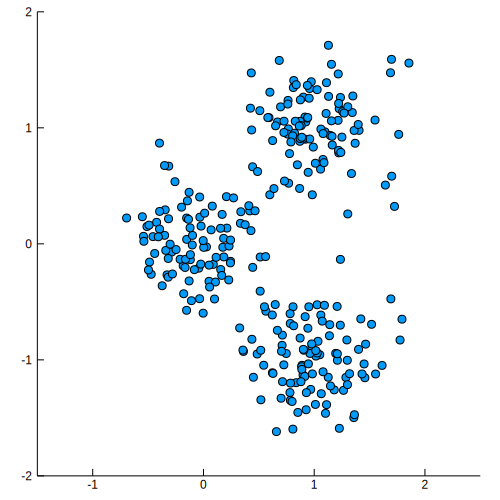

In [11]:
X = vcat( [ 0.3 * randn(2) for i = 1:100 ],
                 [ [1, 1] + 0.3 * randn(2) for i = 1:100 ],
                 [ [1, -1] + 0.3 * randn(2) for i = 1:100 ] );
scatter([x[1] for x in X], [x[2] for x in X])
plot!(legend = false, grid = false, size = (500, 500),
             xlims = (-1.5, 2.5), ylims = (-2, 2))

![図4.1](fig4-1.pdf)

図4.1 2次元平面の300点


1行目ではベクトルの配列を3つ生成している．これらのベクトルは100次元であり，要素はそれぞれ$(0,0), (1,1), (1,-1)$を中心としたランダムな値である．これらの配列を`vcat`を使って一つの300点の配列にした．

次に先程定義した`kmeans`関数を適用して，3つのクラスタの図を作成する（図4.2）．

In [12]:
assignment, reps = kmeans(X, 3);

Iteration 1: Jclust = 0.9461823941214298.
Iteration 2: Jclust = 0.48657185582086004.
Iteration 3: Jclust = 0.4466627225811245.
Iteration 4: Jclust = 0.34744372528180945.
Iteration 5: Jclust = 0.19832790266676684.
Iteration 6: Jclust = 0.17897502537867493.
Iteration 7: Jclust = 0.17862891920855464.
Iteration 8: Jclust = 0.17862891920855464.


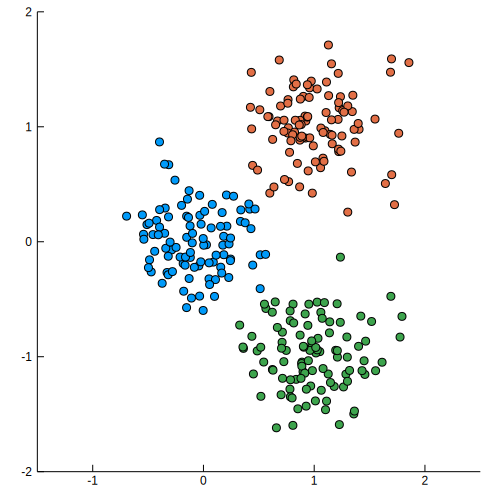

In [13]:
N = 300;
k = 3;
grps  = [[X[i] for i=1:N if assignment[i] == j] for j=1:k];
scatter([c[1] for c in grps[1]], [c[2] for c in grps[1]])
scatter!([c[1] for c in grps[2]], [c[2] for c in grps[2]])
scatter!([c[1] for c in grps[3]], [c[2] for c in grps[3]])
plot!(legend = false, grid = false, size = (500, 500),
              xlims = (-1.5, 2.5), ylims = (-2, 2))

![図4.2](fig4-2.pdf)

図4.2 クラスタリング結果


## 4.4 例

### 4.4.1 画像のクラスタリング

### 4.4.2 文書トピックの抽出

`kmeans`関数を，本書4.4.2節の文書トピック抽出の例題に適用する．
`VMLS`パッケージの関数`wikipedia_data`から
単語ヒストグラム，辞書，文書タイトルを得ることができる．
クラスタリング結果は`kmeans`関数の（ランダムな）初期割り当てに依存する．
以下のコードは，表4.1と表4.2のために用いた初期割り当ての結果である．

In [22]:
articles, dictionary, titles = wikipedia_data();
N = length(articles);
k = 9;
assignment, reps = kmeans(articles, k);
d = [ norm(articles[i] - reps[assignment[i]]) for i = 1:N ];

Iteration 1: Jclust = 0.008208102249490479.
Iteration 2: Jclust = 0.007516687809948743.
Iteration 3: Jclust = 0.0071517558044084445.
Iteration 4: Jclust = 0.0070190602263127825.
Iteration 5: Jclust = 0.006932821355048499.
Iteration 6: Jclust = 0.006916382281536801.
Iteration 7: Jclust = 0.0069124980940857535.
Iteration 8: Jclust = 0.0069111434127000085.
Iteration 9: Jclust = 0.006910755565171603.
Iteration 10: Jclust = 0.006910755565171603.


In [23]:
for j = 1:k
group = [ i for i=1:N if assignment[i] == j ]
println()
println("Cluster ", j, " (", length(group), " articles)")
I = sortperm(reps[j], rev=true)
println("Top words: \n    ", dictionary[I[1:5]]);
println("Documents closest to representative: ")
I = sortperm(d[group])
for i= 1:5
    println("  ", titles[group[I[i]]])
end
end


Cluster 1 (21 articles)
Top words: 
    ["fight", "win", "event", "champion", "fighter"]
Documents closest to representative: 
  Floyd_Mayweather,_Jr.
  Kimbo_Slice
  Ronda_Rousey
  Jose_Aldo
  Joe_Frazier

Cluster 2 (14 articles)
Top words: 
    ["match", "championship", "win", "event", "style"]
Documents closest to representative: 
  Wrestlemania_32
  Payback_(2016)
  Royal_Rumble_(2016)
  Night_of_Champions_(2015)
  Survivor_Series_(2015)

Cluster 3 (120 articles)
Top words: 
    ["united", "party", "president", "government", "india"]
Documents closest to representative: 
  Mahatma_Gandhi
  Carly_Fiorina
  Marco_Rubio
  Sigmund_Freud
  Fidel_Castro

Cluster 4 (40 articles)
Top words: 
    ["series", "season", "episode", "film", "television"]
Documents closest to representative: 
  The_X-Files
  Game_of_Thrones
  House_of_Cards_(U.S._TV_series)
  American_Horror_Story
  Supergirl_(U.S._TV_series)

Cluster 5 (45 articles)
Top words: 
    ["season", "game", "team", "win", "play"]
Docu

## 4.5 応用